In [13]:
import numpy as np
import random
import math
from collections import deque
import matplotlib.pyplot as plt
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

In [10]:
m = 10 # number of locations, ranges from 1 ..... m
t = 24 # number of hours, ranges from 0 .... t-1
d = 30 # number of days, ranges from 0 ... d-1
episode_length = 10000
fixed_act_Set = 15
epsilon = 0.99
learning_rate = 0.01
batch_size = 50
gamma = 0.95
epsilon_min = 0.01
epsilon_decay = 0.995
Time_matrix = np.random.randint(1, 11,(m, m))
actions = []
for i in range(m):
    for j in range(m):
        actions.append([i,j])
states = []
for i in range(m):
    for j in range(t):
        for k in range(d):
            states.append([i,j,k])

In [3]:
def state_trans(state,action,m,t,d):
    state_encod = np.zeros(m+t+d+m+m)
    state_encod.reshape(1,84)
    state_encod[current_state[0]] = 1
    state_encod[m+current_state[1]] = 1
    state_encod[m+t+current_state[2]] = 1
    state_encod[m+t+d+action[0]] = 1
    state_encod[m+t+d+m+action[1]] = 1
    return state_encod   

In [4]:
def act(Q_value,epsilon,actions):
    if np.random.rand() <= epsilon:
        index = np.random.randint(0, m*m,(1, 1))
        if actions[np.int(index)][0] == actions[np.int(index)][1] and actions[np.int(index)][1] != 0:
            return act(Q_value,epsilon,actions)
        else:
            return index
    else:
        index = np.argmax(Q_value)
        if actions[np.int(index)][0] == actions[np.int(index)][1] and actions[np.int(index)][1] != 0:
            return act(Q_value,epsilon,actions)
        else:
            return index

In [5]:
def reward_func(state, action, time_matrix):
    start_loc, time, day = state
    pickup, drop = action
    if pickup == 0 and drop == 0:
        return -1
    else:
        return time_matrix[pickup, drop] - time_matrix[start_loc, pickup]

In [6]:
def next_state_func(state, action, time_matrix, t, d):
    start_loc, time, day = state
    pickup, drop = action
    if pickup == 0 and drop == 0:
        time_elapsed = 1
        drop = start_loc
    else:
        time_elapsed = time_matrix[start_loc, pickup] + time_matrix[pickup, drop]
    time_next = (time + time_elapsed) % t
    day_next = (day + (time + time_elapsed)//t) % d
    return drop, time_next, day_next

In [7]:
def prediction_DQN(m,t,d,actions,X,index_State):
    state_pred = X[0:m+t+d]
    X_test = np.zeros((len(actions), t+d+3*m))
    for i in range(len(actions)):
        action_encod_p = np.zeros(m+m)
        action_encod_p[actions[i][0]] = 1
        action_encod_p[m + actions[i][1]] = 1
        dummy = np.hstack((state_pred,action_encod_p))
        X_test[i,:] = dummy
    prediction = model.predict(X_test)
    prediction = prediction.reshape(len(actions))
    return prediction

In [8]:
# Deep learning model
model = Sequential()
model.add(Dense(100, input_dim = np.int(m+t+d+m+m),activation ='relu'))
model.add(Dense(100,activation ='relu'))
model.add(Dense(1,activation ='linear'))
model.compile(loss='mse',optimizer=Adam(lr=learning_rate))

In [11]:
# code for genrating episode
memory = deque(maxlen=2000)
current_state =  (np.random.randint(0, m),np.random.randint(0, t),np.random.randint(0, d))
count  =  0
Reward_list = []
for epi_len in range(episode_length):
    # pick a random action
    count = count + 1
    index_State = states.index([current_state[0],current_state[1],current_state[2]])
    X = state_trans(current_state,[0,0],m,t,d)
    action = actions[np.int(act(prediction_DQN(m,t,d,actions,X,index_State),epsilon,actions))]
    reward = reward_func(current_state, action, Time_matrix)
    Reward_list.append(reward)
    next_state = next_state_func(current_state, action, Time_matrix, t, d)
    X = state_trans(current_state,action,m,t,d)
    #print("State: ",current_state, " Action: ", action, " Reward: ", reward, " Nextstate: ", next_state)
    index_Next_State = states.index([next_state[0],next_state[1],next_state[2]])
    memory.append((X,reward,index_Next_State))
    current_state = next_state
    if count > batch_size:
        mini_batch = random.sample(memory, batch_size)
        target_mini_batch = np.zeros((batch_size, 1))
        input_mini_batch = np.zeros((batch_size, t+d+3*m))
        for i in range(batch_size):
            X, reward, index_Next_state = mini_batch[i]
            target = reward + gamma*np.argmax(prediction_DQN(m,t,d,actions,X,index_Next_State))
            input_mini_batch[i, :] = X
            target_mini_batch[i, :] = target
        model.fit(input_mini_batch,target_mini_batch, epochs = 1, verbose = 0)
        if epsilon > epsilon_min:
            epsilon *= epsilon_decay
    if epi_len % 50 == 0:
        print("Reward:{},Episode:{}, Epsilon:{}".format(reward,epi_len,epsilon))

Reward:-1,Episode:0, Epsilon:0.99
Reward:0,Episode:50, Epsilon:0.98505
Reward:5,Episode:100, Epsilon:0.7666767843404657
Reward:4,Episode:150, Epsilon:0.5967141684651915
Reward:-1,Episode:200, Epsilon:0.46443013029723174
Reward:7,Episode:250, Epsilon:0.36147180229136094
Reward:1,Episode:300, Epsilon:0.28133804274959967
Reward:-4,Episode:350, Epsilon:0.21896893145312793
Reward:3,Episode:400, Epsilon:0.17042626895787213
Reward:-3,Episode:450, Epsilon:0.13264490518426955
Reward:7,Episode:500, Epsilon:0.10323919533609638
Reward:4,Episode:550, Epsilon:0.0803523621117462
Reward:8,Episode:600, Epsilon:0.06253925242169864
Reward:2,Episode:650, Epsilon:0.0486750854694935
Reward:0,Episode:700, Epsilon:0.03788443023729618
Reward:-2,Episode:750, Epsilon:0.029485927771078575
Reward:3,Episode:800, Epsilon:0.022949267841049455
Reward:8,Episode:850, Epsilon:0.017861703336220346
Reward:8,Episode:900, Epsilon:0.013901987997215145
Reward:7,Episode:950, Epsilon:0.010820091826450088
Reward:5,Episode:1000, E

Reward:2,Episode:7950, Epsilon:0.009986199510890026
Reward:7,Episode:8000, Epsilon:0.009986199510890026
Reward:7,Episode:8050, Epsilon:0.009986199510890026
Reward:4,Episode:8100, Epsilon:0.009986199510890026
Reward:4,Episode:8150, Epsilon:0.009986199510890026
Reward:5,Episode:8200, Epsilon:0.009986199510890026
Reward:7,Episode:8250, Epsilon:0.009986199510890026
Reward:8,Episode:8300, Epsilon:0.009986199510890026
Reward:2,Episode:8350, Epsilon:0.009986199510890026
Reward:-5,Episode:8400, Epsilon:0.009986199510890026
Reward:9,Episode:8450, Epsilon:0.009986199510890026
Reward:7,Episode:8500, Epsilon:0.009986199510890026
Reward:7,Episode:8550, Epsilon:0.009986199510890026
Reward:7,Episode:8600, Epsilon:0.009986199510890026
Reward:8,Episode:8650, Epsilon:0.009986199510890026
Reward:6,Episode:8700, Epsilon:0.009986199510890026
Reward:8,Episode:8750, Epsilon:0.009986199510890026
Reward:8,Episode:8800, Epsilon:0.009986199510890026
Reward:9,Episode:8850, Epsilon:0.009986199510890026
Reward:8,Ep

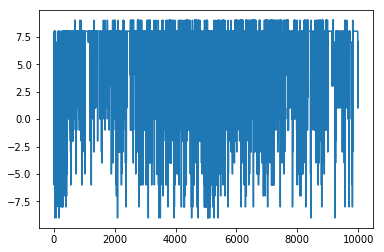

In [14]:
plt.plot(Reward_list)
plt.show()